<a href="https://colab.research.google.com/github/mgb9/BDAO_2122/blob/main/Text%20Mining/Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling using LDA**

Latent Dirichlet Allocation (LDA) is a classical way to do topic modeling. Topic modeling is unsupervised learning and the goal is to group different documents to the same “topic”.

## **1. Text cleaning & Text processing**
Before you do topic modeling, you need make sure you clean and process the text. Please check the text processing notebook to follow the steps. Here we still use the same dataset and copy some codes from previous notebook.

In [ ]:
# Let's import data first
# Run the code and upload the csv file from your laptop
from google.colab import files
uploaded = files.upload()

Saving Reviews.csv to Reviews.csv


In [ ]:
# once you upload the data to the cloud, you can read the data into dataframe. 
# Remember, if you close the notebook or disconnect, you need to upload the file (run the code above) again before you read data.

import io
import pandas as pd
df = pd.read_csv('Reviews.csv') # change the csv file name to your file name that you uploaded
df.head()

# Our target column is "Review"

,Title,Review,Rating,Date
0,Love this under-all cami tank ?,Originally i bought this in black and white. r...,5,07/06/2018
1,Staple tank!,Love this tank. material and fit are great. lo...,5,01/09/2018
2,Love but also very annoying,"I love this tank, it is so comfortable but it ...",2,30/06/2018
3,"Gorgeous top, straps way too long",I just adore this top! it is so comfy and styl...,4,18/07/2018
4,Great layering piece,This sweater is so comfy and classic - it bala...,5,11/07/2018


In [ ]:
# data cleaning part

import re
import string

# drop data with missing values in the 'Review' column
df = df.dropna(subset=['Review'])

# convert the relevant column to lowercase
df['Review'] = df.Review.str.lower() 

# Remove overspace
df['Review'] = df['Review'].map(lambda x: re.sub('\s{2,}', " ", x))

# Remove punctuation

df['Review'] = df['Review'].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

# This dataset actually is pretty clean, so don't need to run all the steps mentioned previously

In [ ]:
# do tokenisation,lemmatisation and stopwords removal

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# create a list of the reviews from the 'Reviews' column
words = df['Review'].tolist()

# tokenise the words
from nltk.tokenize import word_tokenize

# create an empty list to put the tokenised words
word_tokens = [] 
for review in words:
    word_tokens.append(word_tokenize(review))


# remove stopwords
from nltk.corpus import stopwords
# use English stopwords
stopwords = stopwords.words("english")
# you can also extend the stopwords list with more words that you want to remove
stopwords.extend(['re'])

# create a new list with stop words removed
tokens_without_stopwords = []
for review in word_tokens:
    tokens_without_stopwords.append([w for w in review if not w in stopwords])


# lemmatise the words
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# The lemmatizer requires the correct POS tag to be accurate, if you use the default settings of the WordNetLemmatizer.lemmatize(), the default tag is noun.
# Which means the words other than noun would not be lemmatised, and this is not what we expect.
# Therefore we need to define the POS tags ('n' for nouns(default), 'a' for adj, 'v' for verb, 'r' for adverb) which are allowed to be lemmatised.

lemmatised = []
for review in tokens_without_stopwords: 
  n_lemmatised = [lemmatizer.lemmatize(w) for w in review]
  v_lemmatised = [lemmatizer.lemmatize(w,'v') for w in n_lemmatised]
  r_lemmatised = [lemmatizer.lemmatize(w,'r') for w in v_lemmatised]
  a_lemmatised = [lemmatizer.lemmatize(w,'a') for w in r_lemmatised]
  lemmatised.append(a_lemmatised) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# put the tokens back together as text to have our filtered reviews
import string
rejoin = []
for review in lemmatised: # Here we choose to use stemming instead of lemmatisation
    x = " ".join(review) # join the text back together 
    # remove punctuation from the reviews using the string package
    rejoin.append(x)

# add the reformed text to the data frame    
df['filtered_review'] = rejoin

## **2. Vectorisation**

In [ ]:
# vectorise the data into word counts

from sklearn.feature_extraction.text import CountVectorizer

max_words = 1000 #how many words taking account for topic modeling 
vectorizer = CountVectorizer(max_features=max_words)
vec = vectorizer.fit_transform(df['filtered_review'])

## **3. Build the LDA model**

In [ ]:
# fit LDA

from sklearn.decomposition import LatentDirichletAllocation as LDA

k = 5 #this is the number of the topic. you can decide the number
lda = LDA(n_components=k, max_iter=5, learning_method='online')
lda.fit(vec)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=5)

## **4. Visualisation of the topics**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


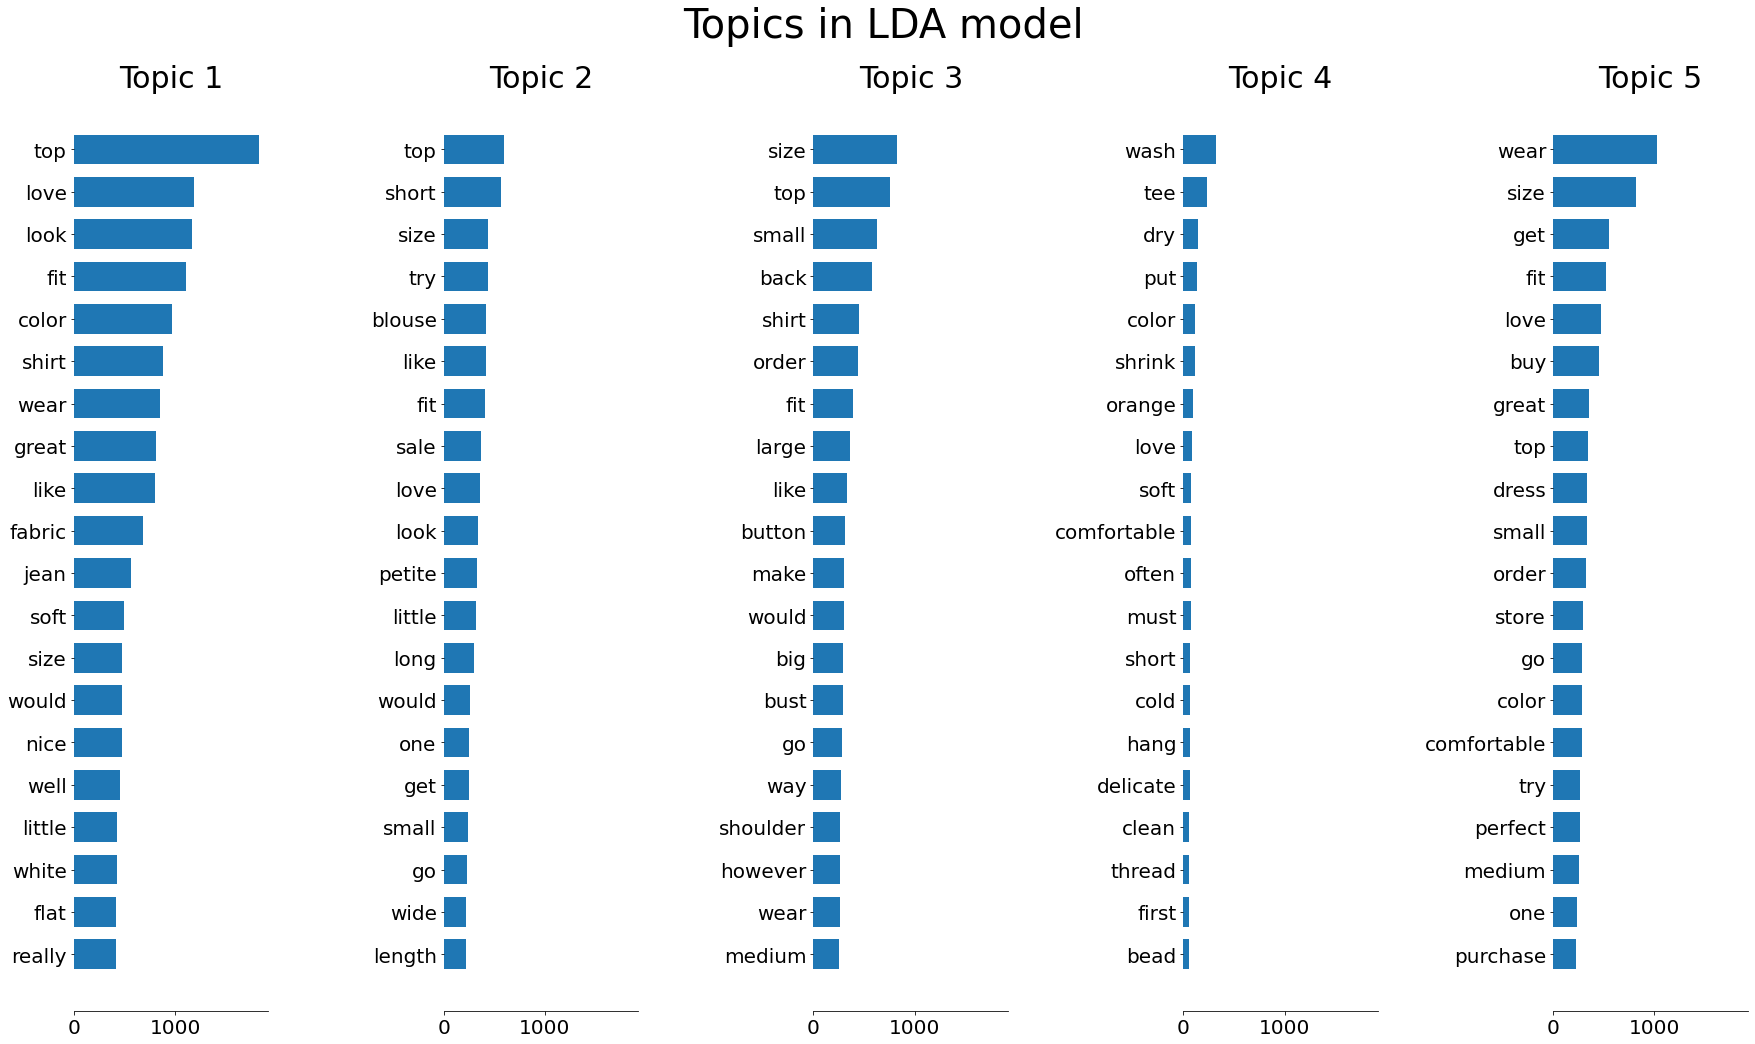

In [ ]:
# Visualise the result into topic clouds

%matplotlib inline
import matplotlib.pyplot as plt

# helper function to plot topics
# see Grisel et al. 
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20  #how many words to be visualised in each topic

# get the list of words (feature names)
vec_feature_names = vectorizer.get_feature_names()

# print the top words per topic
plot_top_words(lda, vec_feature_names, n_top_words, 'Topics in LDA model')

In [ ]:
# visualise the result with pyLDAvis

# !pip install pyLDAvis # install the package for the first time running

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, vec, vectorizer)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.058379 -0.002020       1        1  34.057948
2      0.120001  0.156135       2        1  22.312086
4      0.066911 -0.129371       3        1  20.321845
1      0.112668 -0.039988       4        1  18.186675
3     -0.357958  0.015244       5        1   5.121446, topic_info=       Term         Freq        Total Category  logprob  loglift
947    wash   354.000000   354.000000  Default  30.0000  30.0000
859     tee   255.000000   255.000000  Default  29.0000  29.0000
746   short   902.000000   902.000000  Default  28.0000  28.0000
207   color  1510.000000  1510.000000  Default  27.0000  27.0000
952    wear  2241.000000  2241.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
784    soft    82.476036   721.844427   Topic5  -4.3897   0.8024
504    love    92.371037  2211.464468   Topic5  -4.2764  -0.2039
746   short    71.685115   902.813659   Topic5  -4.5299   0.4385
327  fabric    55.501128  1082.997653   Topic5  -4.7858   0.0006
882    time    49.123370   292.773548   Topic5  -4.9079   1.1867

[363 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
15        3  0.035849         16
15        4  0.950011         16
16        3  0.040585         20
16        4  0.953741         20
18        5  0.981264         26
...     ...       ...        ...
993       3  0.990058     yellow
995       3  0.959113  yesterday
996       2  0.226112        yet
996       3  0.759091        yet
996       5  0.008075        yet

[648 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])